In [5]:
import torch
from torchvision import datasets, transforms

batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

50000 10000 10000


In [7]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

# type(train_loader)
# dir(train_loader)

0
torch.Size([128, 1, 28, 28])
torch.Size([128])
tensor([4, 4, 7, 0, 3, 3])


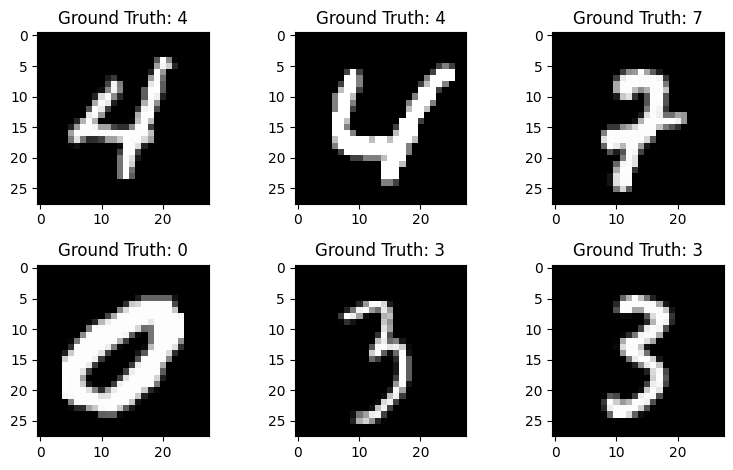

In [8]:
import matplotlib.pyplot as plt

examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)
print(batch_idx)
print(example_data.shape)
print(example_targets.shape)
print(example_targets[0:6])

fig = plt.figure(figsize=(8, 4.8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title(f"Ground Truth: {example_targets[i]}")
plt.show()

In [9]:
import torch.nn as nn

class LinearModel(nn.Module):
    def __init__(self):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)

    def forward(self, x):
        return self.linear(x)


class MLPModel(nn.Module):
    def __init__(self):
        super(MLPModel, self).__init__()
        self.linear1 = nn.Linear(in_features=784, out_features=800, bias=True)
        self.linear2 = nn.Linear(in_features=800, out_features=10, bias=True)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)
        return x

In [10]:
cls_loss = nn.CrossEntropyLoss()

# # input N x Num_class dimension
# # target N dimension with each element represent i-th class
# pred_y = torch.Tensor([[99, 0], [0, 3]])
# true_y1 = torch.Tensor([0, 1]).long()
# true_y2 = torch.Tensor([1, 0]).long()
#
# print(cls_loss(pred_y, true_y1))
# print(cls_loss(pred_y, true_y2))

In [11]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = LinearModel()
num_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of {num_parameters} parameters")

# ===== Construct Optimizer ====== #
lr = 0.005
optimizer = optim.SGD(model.parameters(), lr=lr)

list_epoch = []
list_train_loss = []
list_val_loss = []
list_accuracy = []
list_accuracy_epoch = []

epoch = 30
for i in range(epoch):

    # ====== Train ====== #
    train_loss = 0
    model.train()

    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다.

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)


    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다.

    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.item()

        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다.

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y).sum()

        accuracy = correct.numpy() / len(test_loader.dataset)
        list_accuracy.append(accuracy)
        list_accuracy_epoch.append(i)

    print(f"Epoch: {i}, Train Loss: {train_loss}, Val Loss: {val_loss}, Test Acc: {accuracy*100}%")


Number of 7850 parameters
Epoch: 0, Train Loss: 0.7616740791389095, Val Loss: 0.4889201001275944, Test Acc: 88.49000000000001%
Epoch: 1, Train Loss: 0.43765684680255784, Val Loss: 0.4142598419249812, Test Acc: 89.55%
Epoch: 2, Train Loss: 0.388906226781628, Val Loss: 0.38392527722105196, Test Acc: 90.13%
Epoch: 3, Train Loss: 0.3646328846359497, Val Loss: 0.36621810797649096, Test Acc: 90.53999999999999%
Epoch: 4, Train Loss: 0.3493502107270233, Val Loss: 0.3548919954631902, Test Acc: 90.75999999999999%
Epoch: 5, Train Loss: 0.3383286368206639, Val Loss: 0.3467310938654067, Test Acc: 90.93%
Epoch: 6, Train Loss: 0.3302089364251212, Val Loss: 0.3401239061657387, Test Acc: 91.07%
Epoch: 7, Train Loss: 0.3237471477607327, Val Loss: 0.3349099981633923, Test Acc: 91.28%
Epoch: 8, Train Loss: 0.31854029601949563, Val Loss: 0.3309105206516725, Test Acc: 91.4%
Epoch: 9, Train Loss: 0.31388124419600155, Val Loss: 0.3271578452255152, Test Acc: 91.53%
Epoch: 10, Train Loss: 0.3098447609435567, Va

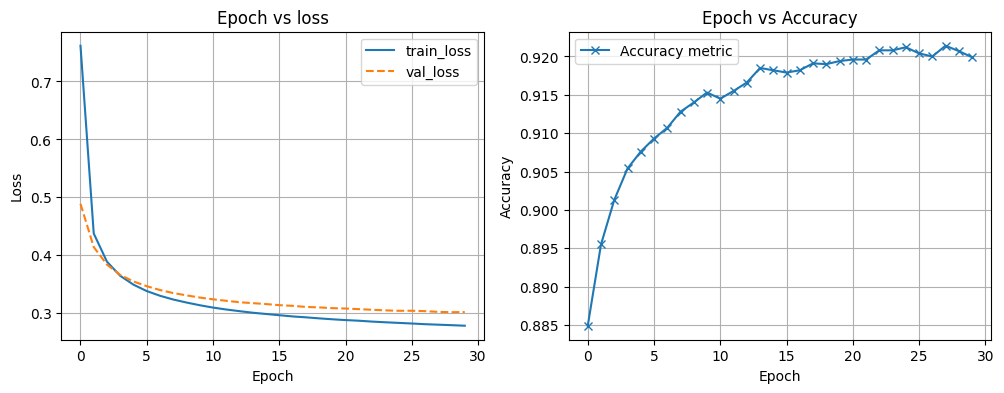

In [13]:
fig = plt.figure(figsize=(12,4))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(121)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid()
ax1.legend()
ax1.set_title('Epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(122)
ax2.plot(list_accuracy_epoch, list_accuracy, marker='x', label='Accuracy metric')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.grid()
ax2.legend()
ax2.set_title('Epoch vs Accuracy')

plt.show()